Original data shape: (569, 30)
Covariance matrix shape: (30, 30)
Explained variance by PC1: 0.44272025607526366
Explained variance by PC2: 0.1897118204403309


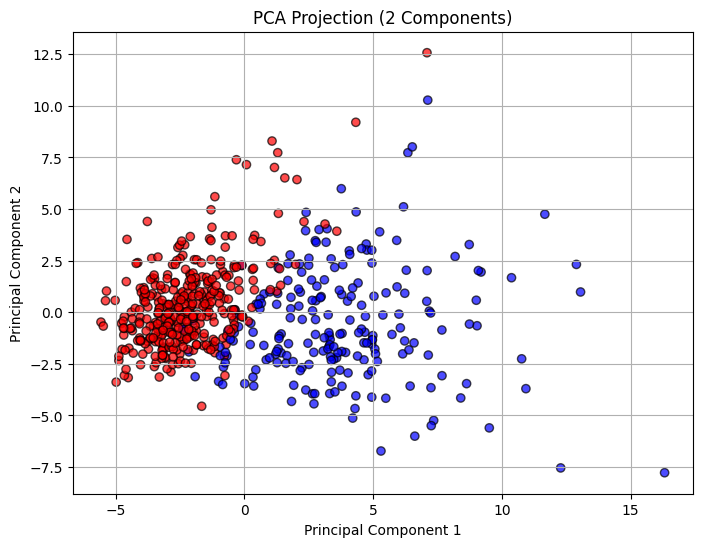

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#Load Dataset
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
print("Original data shape:", X.shape)

#Standardize Features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#Compute Covariance Matrix
cov_matrix = np.cov(X_std.T)
print("Covariance matrix shape:", cov_matrix.shape)

#Eigen Decomposition
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Step 5: Sort Eigenvalues and Eigenvectors
idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

#Calculate Explained Variance
explained_variances = eig_vals / np.sum(eig_vals)
print("Explained variance by PC1:", explained_variances[0])
print("Explained variance by PC2:", explained_variances[1])

#Project onto First 2 Principal Components
X_pca = X_std.dot(eig_vecs[:, :2])

#Scatter Plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (2 Components)')
plt.grid(True)
plt.show()

Explained variance by PC1: 0.0793
Explained variance by PC2: 0.0666
Total explained variance (PC1 + PC2): 0.1459


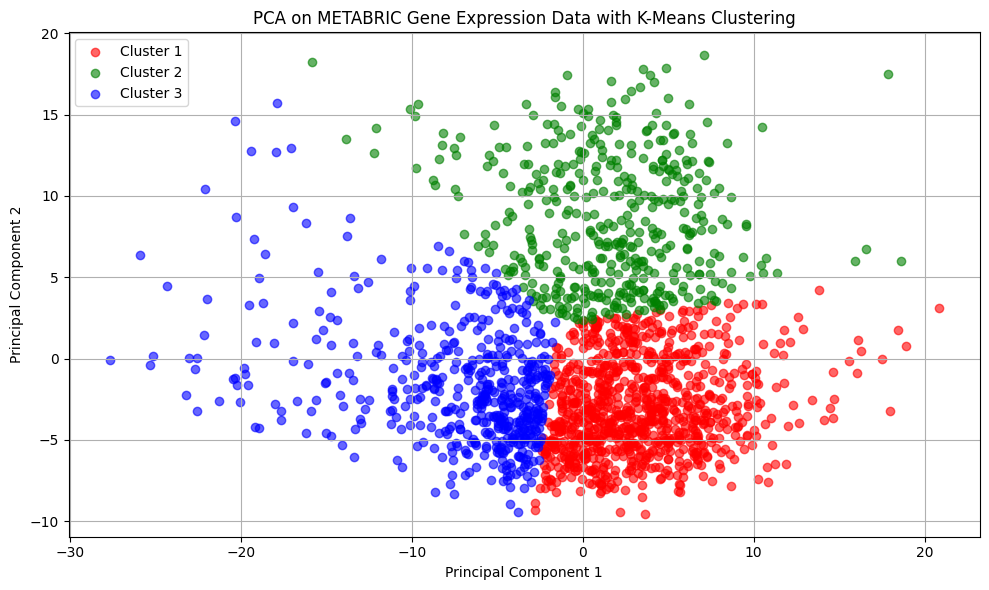

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/METABRIC_RNA_Mutation.csv", low_memory=False)

if 'PATIENT_ID' in df.columns:
    df = df.drop(columns=['PATIENT_ID'])

#Convert all columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

#Drop columns with any NaN values
df_cleaned = df.dropna(axis=1, how='any')

#Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)

#Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.4f}")
print(f"Explained variance by PC2: {explained_variance[1]:.4f}")
print(f"Total explained variance (PC1 + PC2): {explained_variance.sum():.4f}")

#Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pca_result)
clusters = kmeans.labels_

#Plot PCA result
plt.figure(figsize=(10, 6))

colors = ['red', 'green', 'blue']
for cluster_id in np.unique(clusters):
    plt.scatter(
        pca_result[clusters == cluster_id, 0],
        pca_result[clusters == cluster_id, 1],
        c=colors[cluster_id],
        label=f'Cluster {cluster_id + 1}',
        alpha=0.6
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA on METABRIC Gene Expression Data with K-Means Clustering")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [5]:
data = load_breast_cancer()
X = data.data
y = data.target

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [9]:
def logistic_map(seed, r=3.99, size=1):
    result = []
    for _ in range(size):
        seed = r * seed * (1 - seed)
        result.append(seed)
    return np.array(result)


In [10]:
class ChaoticLayer(nn.Module):
    def __init__(self, in_f, out_f, seed=0.5):
        super().__init__()
        self.linear = nn.Linear(in_f, out_f)
        chaos = logistic_map(seed, size=in_f * out_f).reshape(out_f, in_f)
        self.linear.weight.data = torch.tensor(chaos, dtype=torch.float32)
        self.linear.bias.data.fill_(0.0)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [11]:
class ChaoticNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = ChaoticLayer(30, 16)
        self.layer2 = ChaoticLayer(16, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return torch.sigmoid(self.output(x))


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix

model = ChaoticNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model for 100 epochs
for epoch in range(100):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute training accuracy
    with torch.no_grad():
        train_preds = (y_pred > 0.5).float()
        train_acc = accuracy_score(y_train.numpy(), train_preds.numpy())

    # Validate every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)

            val_preds_binary = (val_pred > 0.5).float()
            val_acc = accuracy_score(y_val.numpy(), val_preds_binary.numpy())
            conf_matrix = confusion_matrix(y_val.numpy(), val_preds_binary.numpy())

        print(f"Epoch {epoch+1}")
        print(f"Train Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_acc:.4f}")
        print(f"Validation Confusion Matrix:\n{conf_matrix}")
        print("-" * 50)


Epoch 10
Train Loss: 0.7240, Train Accuracy: 0.6276
Val Loss: 0.7208, Val Accuracy: 0.6228
Validation Confusion Matrix:
[[ 0 43]
 [ 0 71]]
--------------------------------------------------
Epoch 20
Train Loss: 0.7017, Train Accuracy: 0.3490
Val Loss: 0.7007, Val Accuracy: 0.3246
Validation Confusion Matrix:
[[ 2 41]
 [36 35]]
--------------------------------------------------
Epoch 30
Train Loss: 0.6863, Train Accuracy: 0.6276
Val Loss: 0.6843, Val Accuracy: 0.6228
Validation Confusion Matrix:
[[ 0 43]
 [ 0 71]]
--------------------------------------------------
Epoch 40
Train Loss: 0.6674, Train Accuracy: 0.6276
Val Loss: 0.6660, Val Accuracy: 0.6228
Validation Confusion Matrix:
[[ 0 43]
 [ 0 71]]
--------------------------------------------------
Epoch 50
Train Loss: 0.6437, Train Accuracy: 0.6276
Val Loss: 0.6413, Val Accuracy: 0.6228
Validation Confusion Matrix:
[[ 0 43]
 [ 0 71]]
--------------------------------------------------
Epoch 60
Train Loss: 0.6042, Train Accuracy: 0.627

In [13]:
model.eval()
with torch.no_grad():
    test_pred = model(X_test)
    predicted_classes = (test_pred > 0.5).float()
    accuracy = accuracy_score(y_test, predicted_classes)

print(f"\n✅ Test Accuracy: {accuracy:.4f}")


✅ Test Accuracy: 0.9561
